In [ ]:
!unzip drive/MyDrive/yolo_apple_data.zip

In [ ]:
#!unzip /content/drive/MyDrive/Accuracy-2024.zip

In [ ]:
!unzip count_labels

**DATA PREPARATION**


In [5]:
import cv2
import os

train_data = []

for fname in os.listdir("/content/data/images/train"):
  fname_indl = fname.rfind("/") + 1
  fname_indr = fname.rfind(".")

  with open("/content/labels/" + fname[fname_indl:fname_indr]+".txt", "r") as f:
    apple_count = f.read()
  train_data.append([cv2.imread("/content/data/images/train/" + fname), apple_count])

In [6]:
print(train_data[0][1])
print(len(train_data))

92
536


In [7]:
import random

random.shuffle(train_data)

In [8]:
import numpy as np

X = []
y=  []

for img, label in train_data:
  X.append(np.resize(img,(640, 360, 3)))
  y.append(int(label))

In [9]:
X = np.array(X)
print(X.shape)

(536, 640, 360, 3)


In [10]:
y = np.array(y)

In [ ]:
np.save("drive/MyDrive/X.npy", X)
np.save("drive/MyDrive/y.npy", y)

In [1]:
import numpy as np

X = np.load("drive/MyDrive/X.npy")
y = np.load("drive/MyDrive/y.npy")

In [3]:
print(X.shape, y.shape)

(536, 640, 360, 3) (536,)


In [ ]:
print(type(y[1]))

<class 'numpy.int64'>


In [4]:
X = X/255.0

**CNN ARCHITECTURE**

In [3]:
#SIMPLER NET

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

input_shape=(640, 360, 3)

input_tensor = layers.Input(shape=input_shape)

x = layers.BatchNormalization()(input_tensor)
x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(1024)(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU(alpha=0.1)(x)

output_tensor = layers.Dense(1, activation = 'linear')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 640, 360, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 640, 360, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 640, 360, 32)      2432      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 640, 360, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 320, 180, 32)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 320, 180, 32)      128   

**TRAINING**

In [5]:
n_batches = 61

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoints_512_layer_batch_8/cp-{epoch:04d}.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1, save_freq=5*n_batches)


model.compile(optimizer='adam', loss='mean_squared_error', metrics = tf.keras.metrics.RootMeanSquaredError())

model.fit (X, y, batch_size =8, epochs = 100, validation_split = 0.1,  callbacks=[cp_callback])

Epoch 1/100
61/61 [==============================] - 30s 262ms/step - loss: 941.7267 - root_mean_squared_error: 30.6876 - val_loss: 5548.9697 - val_root_mean_squared_error: 74.4914
Epoch 2/100
61/61 [==============================] - 8s 134ms/step - loss: 795.7597 - root_mean_squared_error: 28.2092 - val_loss: 1009.2830 - val_root_mean_squared_error: 31.7692
Epoch 3/100
61/61 [==============================] - 8s 137ms/step - loss: 703.7760 - root_mean_squared_error: 26.5288 - val_loss: 725.3077 - val_root_mean_squared_error: 26.9315
Epoch 4/100
61/61 [==============================] - 8s 132ms/step - loss: 568.7383 - root_mean_squared_error: 23.8482 - val_loss: 675.4890 - val_root_mean_squared_error: 25.9902
Epoch 5/100
60/61 [============================>.] - ETA: 0s - loss: 491.5433 - root_mean_squared_error: 22.1708
Epoch 5: saving model to /content/checkpoints_512_layer_batch_8/cp-0005.ckpt
61/61 [==============================] - 8s 133ms/step - loss: 492.3222 - root_mean_squared

In [ ]:
import re

text = ' '      #copy required output
val_rmse_values = re.findall(r'val_root_mean_squared_error: (\d+\.\d+)', text)

val_rmse_values = [float(value) for value in val_rmse_values]

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]


<function matplotlib.pyplot.show(close=None, block=None)>

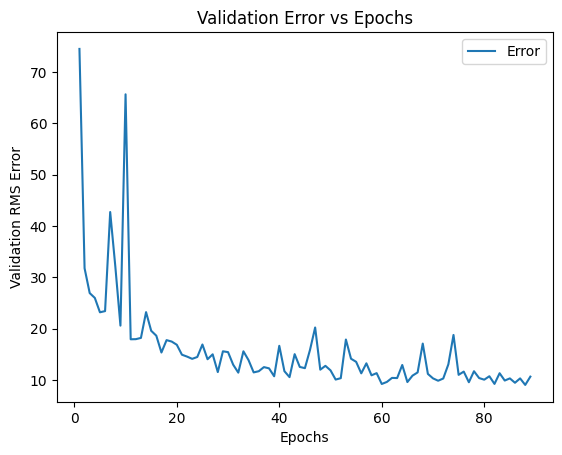

In [9]:
import matplotlib.pyplot as plt

x = np.arange(1,90)

plt.plot(x, val_rmse_values, label='Error')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation RMS Error')
plt.title('Validation Error vs Epochs')
plt.show

**TEST DATA**

In [4]:
model.load_weights('/content/drive/MyDrive/simpler_net_batch_8/cp-0090.ckpt')                    ##remove the characters after ckpt for file path


In [14]:
!cp /content/data/images/val/* /content/data/images/test/                  #Since we used validation split for training data, this wasn't used for training

In [ ]:
import cv2
import os
import random
import numpy as np
from google.colab.patches import cv2_imshow

test_data = []

for fname in os.listdir("/content/data/images/test/"):
  fname_indl = fname.rfind("/") + 1
  fname_indr = fname.rfind(".")

  with open("/content/labels/" + fname[fname_indl:fname_indr]+".txt", "r") as f:
    apple_count = f.read()

  test_data.append([cv2.imread("/content/data/images/test/" + fname), apple_count])

random.shuffle(test_data)

X = []
y=  []

for img, label in test_data:
  X.append(np.resize(img,(640, 360, 3)))
  y.append(int(label))

X = np.array(X)
print(X.shape)
print(X[0])
y = np.array(y)

X = X/255.0

In [6]:
model_outputs = model.predict(X).flatten()
print(model_outputs.shape)

5/5 [==============================] - 8s 441ms/step
(134,)


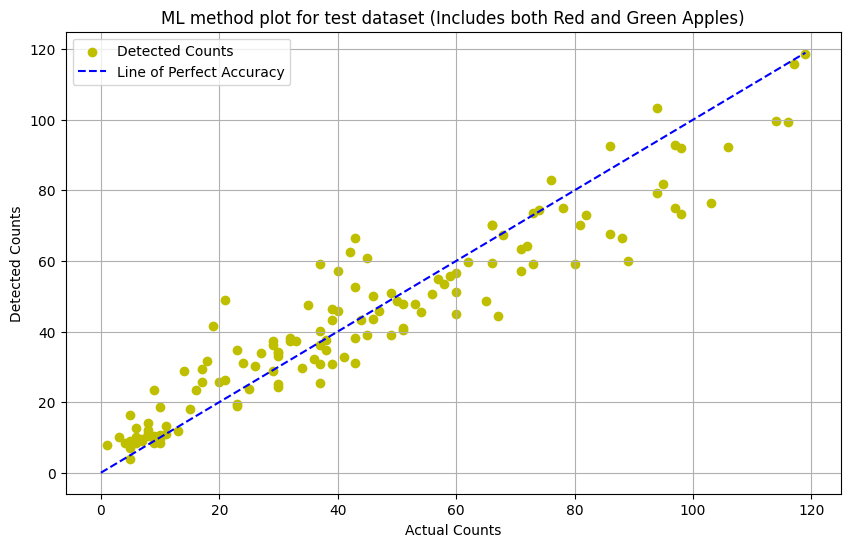

In [17]:
def plot_accuracy(actual_counts, detected_counts, title, color):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_counts, detected_counts, color=color)
    plt.plot([0, max(actual_counts)], [0, max(actual_counts)], 'b--')
    plt.xlabel('Actual Counts')
    plt.ylabel('Detected Counts')
    plt.title(title)
    plt.legend(['Detected Counts', 'Line of Perfect Accuracy'])
    plt.grid(True)
    plt.show()

plot_accuracy(y, model_outputs, 'ML method plot for test dataset (Includes both Red and Green Apples)', 'y')

In [7]:
##FIND RMS

rms_sum = 0;

for i in range(0, model_outputs.shape[0]):
  rms_sum += (int(model_outputs[i]) - y[i]) **2

rms_sum = np.sqrt(rms_sum/model_outputs.shape[0])

print(rms_sum)

10.210471651362809


In [19]:
#FIND PERCENT ERROR
total_apples = np.sum(y)
total_detected = np.sum(model_outputs)

print(total_detected / total_apples)

0.9872567606358893
